<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 4</h2>

In this part you will take your aligned images and combine them using the same tools that we used to combine our flats.

We took short exposures of every target to deal with saturation.  Note, however, that we can't just combine the short and long exposures and expect the saturation to go away.  In principle we would need to produced combinations of the short and long exposures separately and use photometry from faint stars from our long exposures and from the saturated stars from our bright exposures.  For the sake of expediency we are going to instead just use the long exposures and ignore the brightest stars.


In [1]:
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from matplotlib import pyplot as plt
from ccdproc import Combiner
from astropy.io import ascii
from astropy.io import fits
import os, glob, time

In [2]:
#this specifies the reduction directory
#****
#put your own path
redpath = "/home/b739c775/Documents/astro596/astr596_obsproject-master2/astr596_obsproject-master/Images/"
flatpath = "/home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/"
listpath = "/home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/ReducedData/"

First we write a routine to read in images.

In [3]:
def readimage(filename):
    imgfile = os.path.join('{}'.format(redpath), filename)
    print('Reading {}'.format(imgfile))
    img, hdr = fits.getdata(imgfile, header=True)
    return img,imgfile,hdr

This routine will display an image

In [4]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

This function will do the combination.  

In [5]:
def im_combine(comblist,outfile):
    #filelist is the name of a text file that contains a list of all the files to combine
    comblistpath = listpath + comblist
    
    #initialize a list of files to combine
    comb_imlist = []

    #this way of opening the file ensures that it closes after the loop is done.
    with open(comblistpath,'r') as fp:
        
        #read first line
        iline = 0
        line = fp.readline()

        #build the combine list of all images
        #read every subsequent line
        while line:
            #this removes the trailing newline charactter and converts the output list to a scalar
            imname = line.split()
            imname = imname[0].replace('.fits','bfy.fits',1)
            
            #create the image name, including the path
            imstr = redpath + imname
            #read that into a CCDData object.  This allows you to specify a unit
            im = CCDData.read(imstr)
            
            #read in the image headers
            imtest, hdr = fits.getdata(imstr, header=True) 
            
            #normalize each image by its exposure time.  This allows you to combine images of 
            #different exposure times.
            im = im.divide(hdr['EXP_TIME'] * u.electron)
            
            #make a list of all the CCDData instances of each image
            comb_imlist = comb_imlist + [im]
            print('.', end= '')
        
            line = fp.readline()
            iline = iline + 1

    #Combiner list of all bias images
    im_combiner = Combiner(comb_imlist)
    print('')

    #generate a median combined image
    combined_img = im_combiner.median_combine()

    #now write out this file
    combined_imgpath = redpath + outfile

    #Change the exposure time keyword to reflect that these images have been normalized to 1 second
    hdr['EXP_TIME'] = 1.0
    #this takes the header of the last file in the list writes it as the header of the combined file.
    combined_img.meta = hdr
    combined_img.write(flatpath+outfile, overwrite=True)


In [8]:
#*********
#Here you will need to provide names of lists of your images, and the name of an output file 
#for each combined image
im_combine("sciencelist_R_nova","NovaR.fits")
im_combine("sciencelist_V_nova", "NovaV.fits")
im_combine("sciencelist_B_nova",  "NovaB.fits")
im_combine("sciencelist_V_NGC7128",  "NGC7128V.fits")
im_combine("sciencelist_B_NGC7128",  "NGC7128B.fits")

...............................

<h3> Determine the Astrometry of your image </h3>
   
"Astrometry" is the process of determining where your data are pointing, i.e.,figuring out the transformation matrix between pixel coordinates (x,y) and celestial coordinates (RA,Dec), which has a long, rich history. In a nutshell, this transformation matrix is determined by comparing the observed positions of stars (or other reference sources) against their known positions (i.e., using an external, calibrated catalog).

Needless to say there are many intricacies involved in astrometry, which I encourage you to delve into.  But for now we can proceed with just the basics and use the [astrometry.net](http://astrometry.net) engine to determine the astrometric solution of our data.

In [6]:
#******
#This reads in images into variables that we will use.  You will need to do this for
#every image that you combined
img_ngc7128_V, imgfile_ngc7128_V, hdr_ngc7128_V = readimage(flatpath + "NGC7128V.fits")
img_ngc7128_B, imgfile_ngc7128_B, hdr_ngc7128_B = readimage(flatpath + "NGC7128B.fits")
img_Nova_R, imgfile_Nova_R, hdr_Nova_R = readimage(flatpath + "NovaR.fits")
img_Nova_V, imgfile_Nova_V, hdr_Nova_V = readimage(flatpath + "NovaV.fits")
img_Nova_B, imgfile_Nova_B, hdr_Nova_B = readimage(flatpath + "NovaB.fits")


Reading /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/NGC7128V.fits
Reading /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/NGC7128B.fits
Reading /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/NovaR.fits
Reading /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/NovaV.fits
Reading /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/NovaB.fits


First, we need the observed positions of the stars in this image, but in order to detect those stars we first have to model and subtract the sky background from the data.  This is because we want to detect stars at a certain level above the background and if the background varies across the image this becomes hard.  So we need to create an image with the mean background counts removed.

We'll build the sky background by measuring the median pixel value in a "low-resolution" mesh grid, which we will then interpolate onto the original resolution of the image. For additional details see the photutils tutorial on Background Estimation.

In [7]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(data = img, box_size=(100), filter_size=(10), sigma_clip=sigma_clip, bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

You will need to repeat these commands for each combined image and band combination

In [8]:
#***********
bkg1 = get_sky_background(img_ngc7128_V, verbose=True)
bkg2 = get_sky_background(img_ngc7128_B, verbose=True)
bkg3 = get_sky_background(img_Nova_R, verbose=True)
bkg4 = get_sky_background(img_Nova_V, verbose=True)
bkg5 = get_sky_background(img_Nova_B, verbose=True)

Sky background median = 3.351, rms = 0.066 electrons.
Sky background median = 3.150, rms = 0.063 electrons.
Sky background median = 6.103, rms = 0.118 electrons.
Sky background median = 3.737, rms = 0.074 electrons.
Sky background median = 3.563, rms = 0.072 electrons.


In [9]:
#***********
img_ngc7128_V_nosky = img_ngc7128_V - bkg1.background
img_ngc7128_B_nosky = img_ngc7128_B - bkg2.background
img_Nova_R_nosky = img_Nova_R - bkg3.background
img_Nova_V_nosky = img_Nova_V - bkg4.background
img_Nova_B_nosky = img_Nova_B - bkg5.background


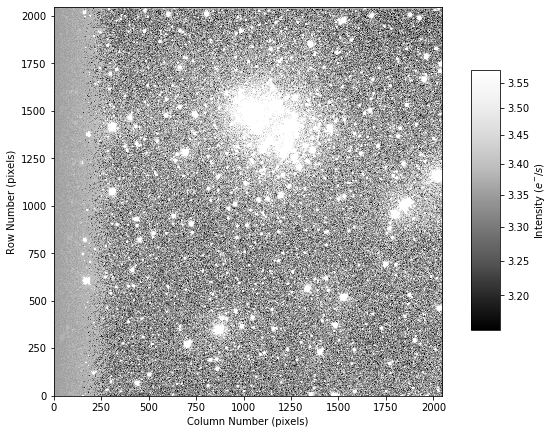

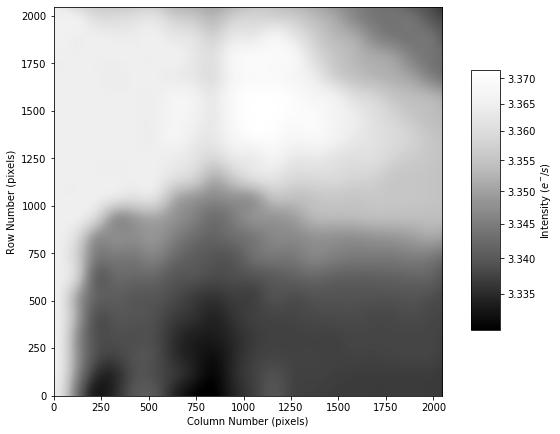

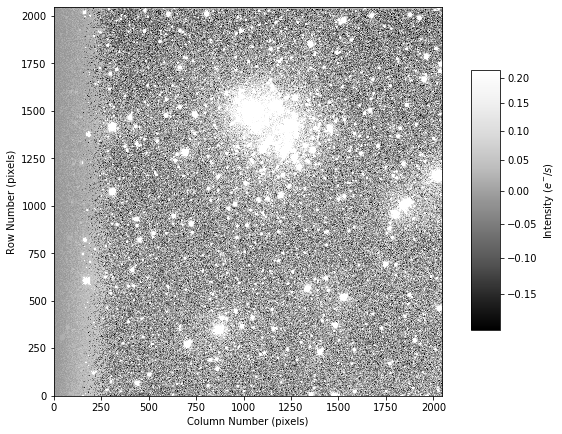

In [49]:
#***********
display_image(img_ngc7128_V, calibrated=True)
display_image(bkg1.background, calibrated=True)
display_image(img_ngc7128_V_nosky,calibrated=True)
#now write out this file
bkgsub_imname = imgfile_ngc7128_V.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_ngc7128_V['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_ngc7128_V_nosky, hdr_ngc7128_V, overwrite=True)



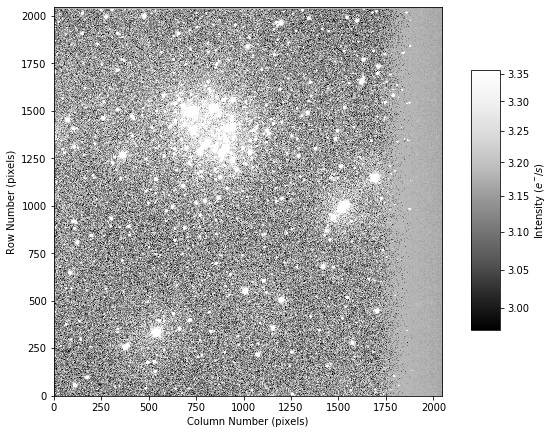

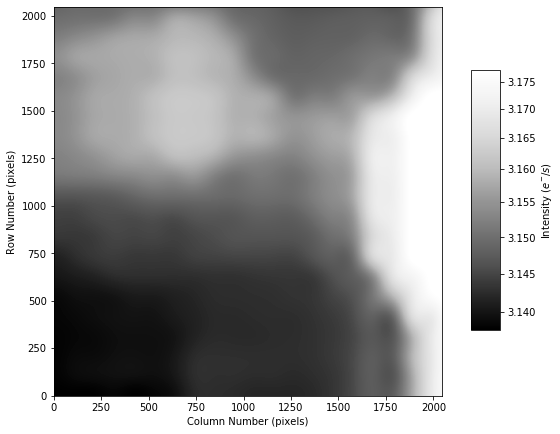

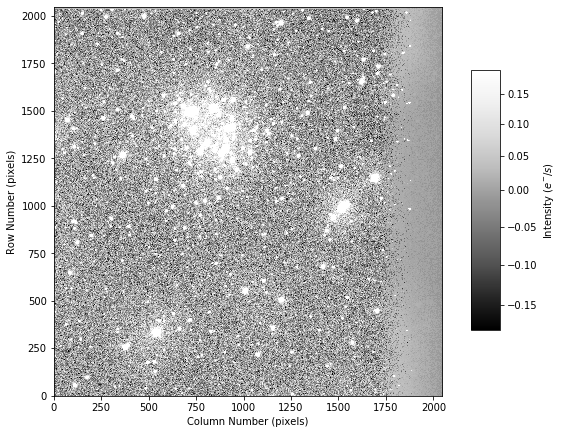

In [50]:
#***********
display_image(img_ngc7128_B, calibrated=True)
display_image(bkg2.background, calibrated=True)
display_image(img_ngc7128_B_nosky,calibrated=True)
#now write out this file
bkgsub_imname = imgfile_ngc7128_B.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_ngc7128_B['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_ngc7128_B_nosky, hdr_ngc7128_B, overwrite=True)



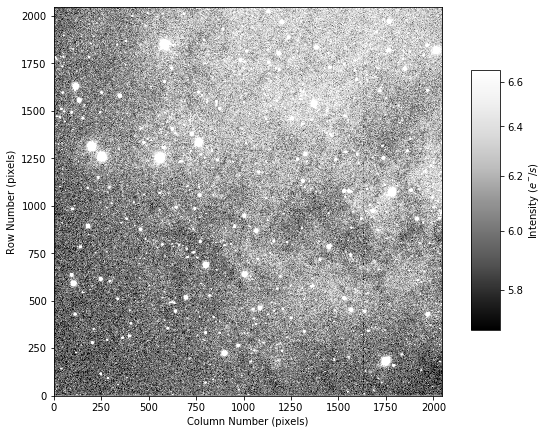

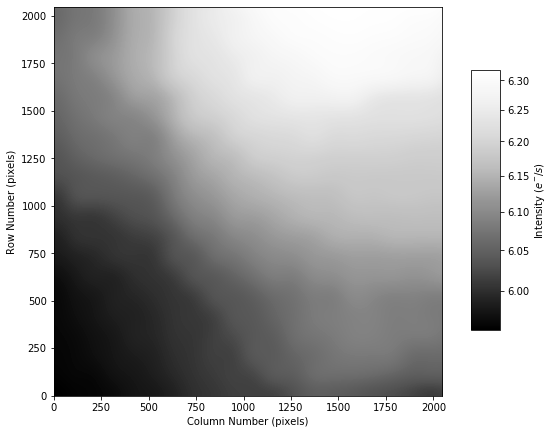

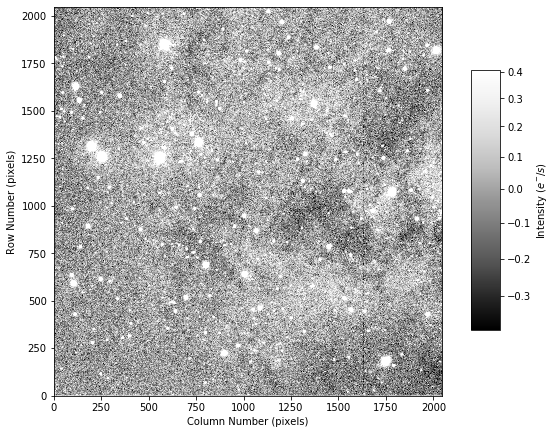

In [51]:
#***********
display_image(img_Nova_R, calibrated=True)
display_image(bkg3.background, calibrated=True)
display_image(img_Nova_R_nosky,calibrated=True)
#now write out this file
bkgsub_imname = imgfile_Nova_R.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_Nova_R['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_Nova_R_nosky, hdr_Nova_R, overwrite=True)



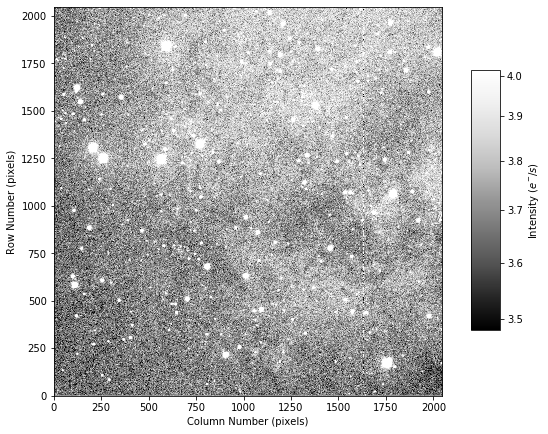

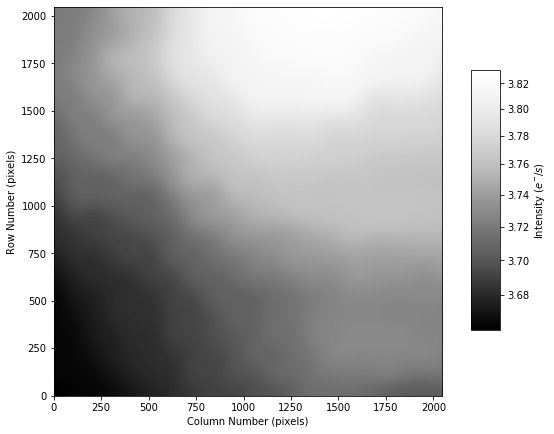

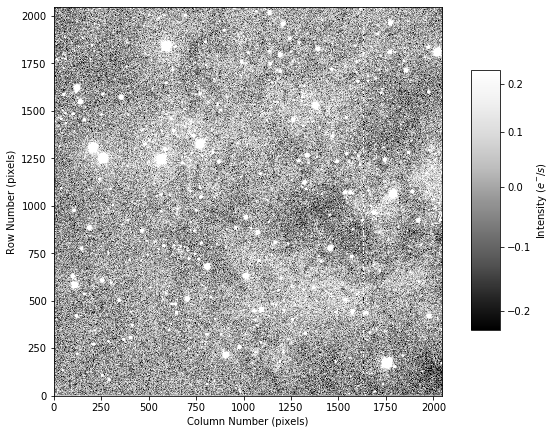

In [52]:
#***********
display_image(img_Nova_V, calibrated=True)
display_image(bkg4.background, calibrated=True)
display_image(img_Nova_V_nosky,calibrated=True)
#now write out this file
bkgsub_imname = imgfile_Nova_V.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_Nova_V['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_Nova_V_nosky, hdr_Nova_V, overwrite=True)



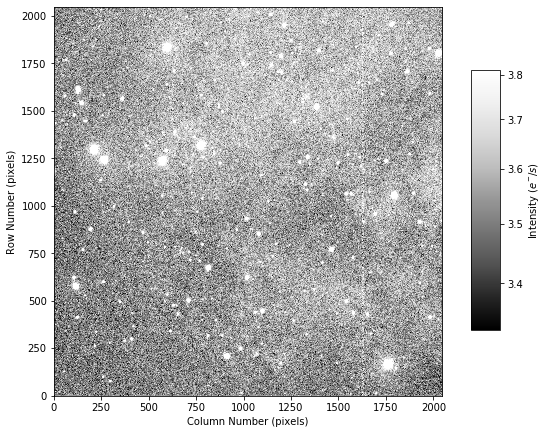

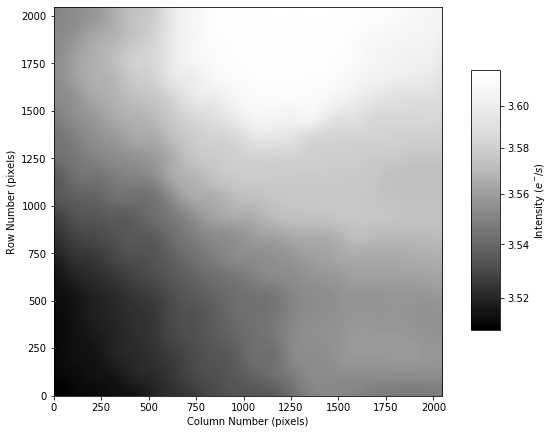

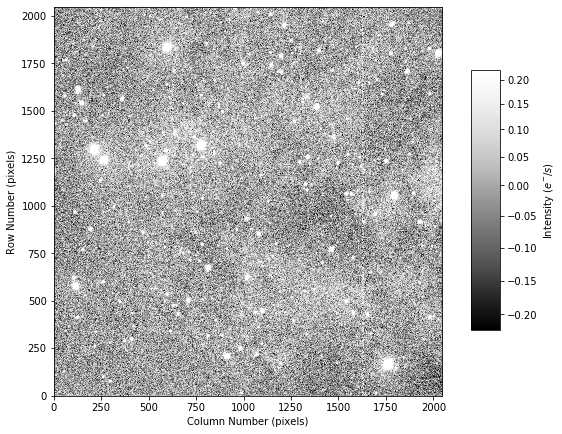

In [53]:
#***********
display_image(img_Nova_B, calibrated=True)
display_image(bkg5.background, calibrated=True)
display_image(img_Nova_B_nosky,calibrated=True)
#now write out this file
bkgsub_imname = imgfile_Nova_B.replace('.fits','bkgsub.fits',1)
bkg_sub_imgpath = bkgsub_imname

#include in the header that we have performed a background subtraction
hdr_Nova_B['BACKGROUND'] = 'Background was Subtracted'

#write the background subtracted image with the header information
fits.writeto(bkg_sub_imgpath, img_Nova_B_nosky, hdr_Nova_B, overwrite=True)



This routine makes histogrames of the original and background subtracted images.

In [10]:
def qa_background(img,img_nosky, bkga):
    med, sig = bkga.background_median, bkga.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkga.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

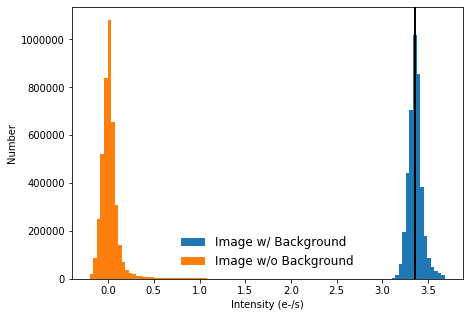

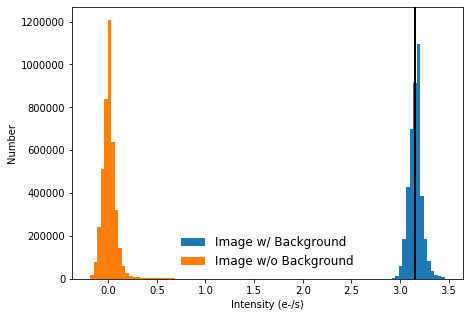

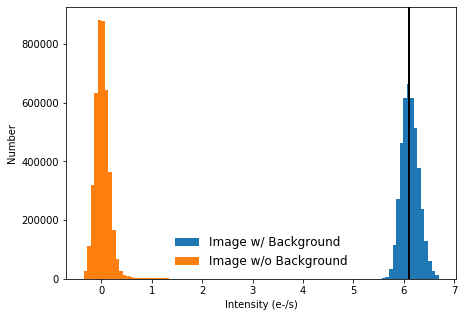

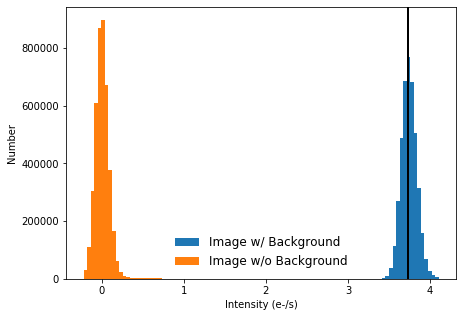

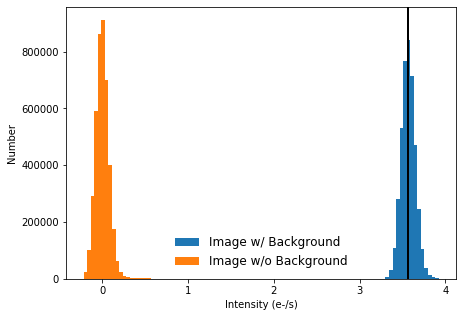

In [11]:
#***********
qa_background(img_ngc7128_V, img_ngc7128_V_nosky, bkg1)
qa_background(img_ngc7128_B, img_ngc7128_B_nosky, bkg2)
qa_background(img_Nova_R, img_Nova_R_nosky, bkg3)
qa_background(img_Nova_V, img_Nova_V_nosky, bkg4)
qa_background(img_Nova_B, img_Nova_B_nosky, bkg5)


In [12]:
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    starsfile = os.path.join(flatpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [13]:
#***********
srcs1 = find_stars(img_ngc7128_V_nosky, imgfile_ngc7128_V, sigma=bkg1.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs1




Read 1627 stars from /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/stars-NGC7128V.fits


<Table length=1627>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  198  866.9443729752703 ...  2149.635750812871     -8.330912190703227
  629 1839.8287876282827 ... 2100.5085627598173     -8.305811140716637
  372 169.74604899670493 ... 2084.5437020959293     -8.297527511164972
  776 2015.3626042479748 ... 2071.7008814612695      -8.29081762706953
 1214 1167.2046441768844 ... 1869.3802297008908     -8.179244113353478
 1087 1237.3528369541639 ... 1756.0848412856953     -8.111363735092823
  772 2015.3024952980193 ... 1630.2676398590424     -8.030647270169908
 1090 1262.4519567351274 ... 1603.6728241225326     -8.012789424253718
  767  2015.257014160604 ... 1524.5491468561365    -7.9578535731709845
  642 1856.8054172275156 ...  1518.725395382463     -7.953698137666779
  ...                ... ...                ...                    ...
 1193 1366.4312623359233 ... 1.0081908349919733  -0.008856862862192717
  254  473.9442004437196 ... 1.0075621418849856  -0.008179602406272024
  145 1984.3218928925555 ... 1.0073586201159035  -0.007960267772307631
  860  781.4424560009886 ... 1.0070529283309675  -0.007630741622394712
  355 165.30427968347973 ... 1.0043485030887778  -0.004711091549505256
 1105 1171.3877919127592 ... 1.0027407622531863 -0.0029716743381597594
  278   1410.65704144747 ... 1.0024613055739686  -0.002669045250427656
  413   912.236508636526 ...  1.001745973895048 -0.0018940141015542182
  276  1024.717625695052 ... 1.0016649008180838 -0.0018061399904067599
  237 1439.2832224021083 ... 1.0005073337258779 -0.0005506909138526109

Visualize the image again with the detected sources overlaid.

In [14]:
srcs2 = find_stars(img_ngc7128_B_nosky, imgfile_ngc7128_B, sigma=bkg2.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs2

Read 649 stars from /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/stars-NGC7128B.fits


<Table length=649>
  id      xcentroid      ...        flux                 mag         
int64      float64       ...      float64              float64       
----- ------------------ ... ------------------ ---------------------
  485  710.1512095845098 ... 1347.2797192251655     -7.82364443085227
   66  538.8422012604146 ... 1059.8187691322314    -7.563079016239744
  492  838.3407508093928 ...  869.3114950832731    -7.347938556069234
  226 1511.4624292964331 ...  770.5167440257086    -7.216955201922136
  290 1686.9124394783585 ...  643.4168464537587    -7.021231069399512
  440  933.7277490603705 ... 450.12825204774157    -6.633340680109905
  379  900.7076117449732 ...  447.9615548779037    -6.628101858539842
  434  730.4709567774116 ...  423.7831020228892   -6.5678590890272845
  355 361.03513919242096 ...   389.227685222439    -6.475509308639531
  233 1528.4353675278549 ...  380.4660636600992    -6.450789812934399
  ...                ... ...                ...                   ...
  307 1594.4342323840083 ... 1.0323125944927636  -0.03452806470753929
  147  28.63683205406673 ... 1.0286492493683848 -0.030668283768085745
  116   720.798693818589 ... 1.0277511321400434  -0.02971990964629996
  124  770.9020230466491 ... 1.0264883977612758  -0.02838511242840718
  239  818.6144834751658 ...  1.025641702305654 -0.027489177065725123
  349  628.2143741932019 ... 1.0251937908532842  -0.02701491797500969
  277 12.877762334921135 ... 1.0221038413916277 -0.023737551268824514
  305  853.7011475670007 ... 1.0209290389693144 -0.022488892300883384
   86 1092.5937263808237 ... 1.0164047869427832 -0.017666754429547283
  372 1234.9096084728142 ... 1.0125380248487734 -0.013528354215310137

In [87]:

srcs3 = find_stars(img_Nova_R_nosky, imgfile_Nova_R, sigma=bkg3.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs3

Found 318 sources
Writing 318 stars to /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/stars-NovaR.fits


<Table length=318>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
   20 1743.7784418778078 ...  706.3703933713948     -7.122581220106925
  297  581.9478297090787 ...  697.5999250295292     -7.109016063128136
  183  556.2248260598958 ...  652.4813659921007     -7.036420283273448
   14 1743.9063068684784 ...  584.8879073673879     -6.917681605904864
  287  582.2488138225527 ...  567.7411391702049     -6.885375912097267
  196 197.88600006460024 ...  548.7369197527676     -6.848410452729547
  143 1775.3791294800467 ...  519.9971106527444     -6.790002326245385
  193 197.57541360545525 ...  409.3607784696916     -6.530265574625622
  177  251.4727824895886 ... 392.09997015875945    -6.4834920231192585
  175  556.4366649657732 ...  387.7011255473145     -6.471242654557478
  ...                ... ...                ...                    ...
  139 282.38819684650866 ... 1.0437477499633316   -0.04648888067929616
  123 1641.9719209881418 ... 1.0360734764350155   -0.03847638967828756
  156 1627.2468049956406 ... 1.0337819163683224   -0.03607232729309873
  157 1244.1270605358732 ... 1.0260944999253823  -0.027968399274324717
  223  583.9507993331886 ... 1.0221904653489151   -0.02382956421076987
  159  976.2925275629748 ... 1.0187457095426227   -0.02016448179121751
   25 1175.6277241268915 ... 1.0167144943354818  -0.017997537315560325
  165 1286.9887524157557 ... 1.0129316178663854  -0.013950318766669592
  169  129.8494615455477 ... 1.0119667925113662  -0.012915653626808368
   92  658.4242052931178 ... 1.0030407778560757 -0.0032964732237461027

In [88]:
srcs4 = find_stars(img_Nova_V_nosky, imgfile_Nova_V, sigma=bkg4.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs4

Found 277 sources
Writing 277 stars to /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/stars-NovaV.fits


<Table length=277>
  id      xcentroid      ...        flux                 mag         
int64      float64       ...      float64              float64       
----- ------------------ ... ------------------ ---------------------
   13 1750.4046154006785 ...  540.6560804125487   -6.8323027289640965
  246 2016.2138483092351 ... 385.54913542842064    -6.465199333954505
  254  588.7530362091911 ... 357.02566211879105    -6.381748583109901
  253   589.016647184264 ... 352.70370826418156    -6.368525064466465
  123 1781.9295003372865 ... 351.40601019694816    -6.364522962712136
  252  588.1493023254803 ...  344.1329796065897    -6.341815736876558
  150  562.3609688333427 ... 334.14342988687014    -6.309832315512741
  153   257.934714864079 ... 330.87768914564026    -6.299168709924374
  166 204.36912106893112 ...  330.5286133816329    -6.298022654227812
  155 258.61047409692884 ... 323.41310615497025   -6.2743940387361725
  ...                ... ...                ...                   ...
   96 1571.4487285414857 ... 1.0261125138152987 -0.027987460053612884
  224  1591.393757624387 ... 1.0230104359897085  -0.02470016020812767
  225  1591.501331956824 ... 1.0212763086695642 -0.022858143405280685
  193 1628.3827400683538 ... 1.0159956954068896 -0.017229669808247774
  181  1362.174521104337 ... 1.0117128930615293 -0.012643211472580292
  214 1317.5027492392817 ...  1.009182610165206 -0.009924395799035986
  117  1122.056769826934 ... 1.0087861580074806 -0.009497786157277695
   50 1629.2906114211826 ... 1.0053889031247178 -0.005835218596021305
  140 0.4191544251246472 ... 1.0047490862103645 -0.005144049715600997
  124 1571.0742847599197 ... 1.0033548877047191 -0.003636426547592794

In [89]:
srcs5 = find_stars(img_Nova_B_nosky, imgfile_Nova_B, sigma=bkg5.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs5

Found 178 sources
Writing 178 stars to /home/b739c775/RFSLAB/USER_DPT/b739c775/ASTR596/Data/Flatcorrected/stars-NovaB.fits


<Table length=178>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
    9 1756.6226223555964 ...  574.6564653491538      -6.89852074307443
    7 1755.5228852589894 ... 398.32876352715255    -6.5006041704301145
    5  1756.331218300857 ...   391.354093390077     -6.481424701767841
    6 1756.6738240196705 ... 367.46382840223674     -6.413036488493017
    8  1756.972526353313 ... 337.24502897608113     -6.319863892122505
  114 210.56096111594277 ... 330.70450259755887    -6.2986002698663714
  164  594.7927434198809 ...  315.7028388091463    -6.2481962177460995
  156 2022.4069173919877 ...  252.5520435075013     -6.005877217316337
  106  264.2288632856437 ...   238.915940191467     -5.945612815838183
  105  568.9911604751757 ... 210.52552824003695     -5.808261914343288
  ...                ... ...                ...                    ...
   80  754.1288683911524 ... 1.0584140839855027  -0.061639025597163555
   45 1624.7363359736783 ... 1.0580526459107222   -0.06126819396363119
   83 314.51626060203307 ... 1.0534946331368238   -0.05658081876158012
  121  634.7656041992061 ... 1.0486288970519655   -0.05155455347404511
   77  1624.749373970436 ...  1.028559036588395   -0.03057306027312106
   57 1085.6584183213247 ... 1.0260930042476717   -0.02796681665924913
   97 1626.3257926176304 ... 1.0145533420441477  -0.015687214540745863
  100 1345.7336274000977 ... 1.0039702932359624   -0.00430215633881686
   60  701.8008357610626 ... 1.0032105188508746 -0.0034801929244905757
   81 1505.6212115115395 ... 1.0029948972271834 -0.0032468088428849913

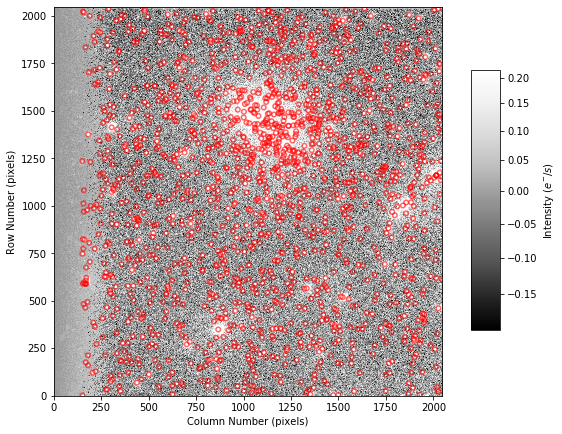

In [90]:
#***********
display_image(img_ngc7128_V_nosky, srcs=srcs1, calibrated=True)

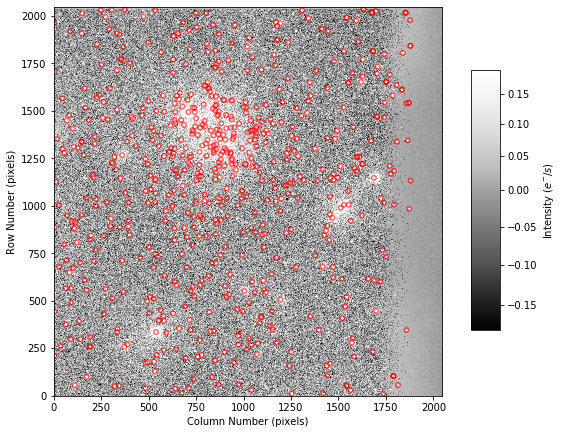

In [15]:
display_image(img_ngc7128_B_nosky, srcs=srcs2, calibrated=True)

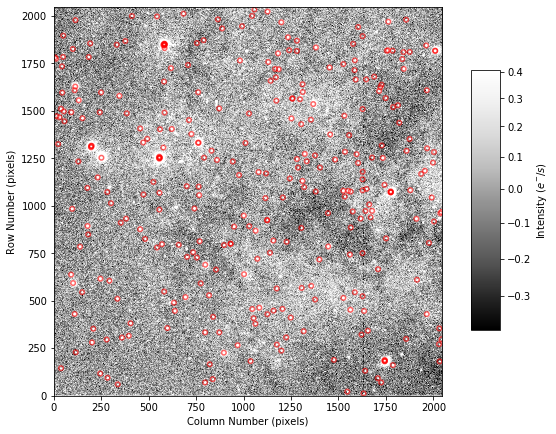

In [73]:
display_image(img_Nova_R_nosky, srcs=srcs3, calibrated=True)

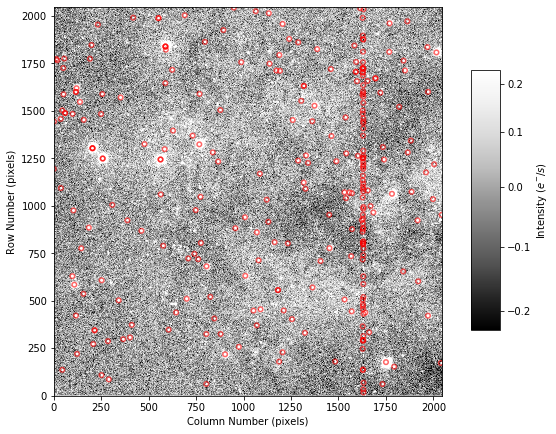

In [74]:
display_image(img_Nova_V_nosky, srcs=srcs4, calibrated=True)

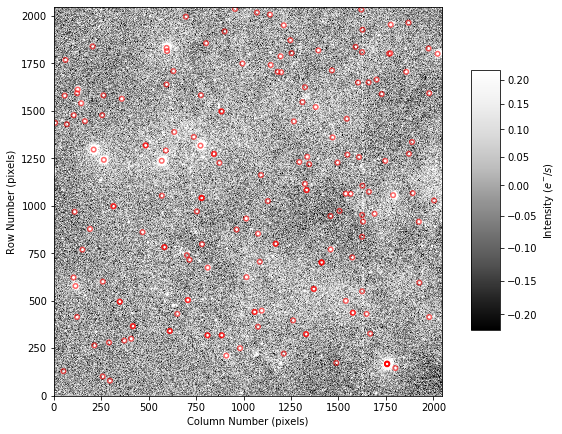

In [75]:
display_image(img_Nova_B_nosky, srcs=srcs5, calibrated=True)

Now we're ready to find the astrometric solution by uploading our table of sources (actually, their x,y positions) to astrometry.net, which returns a FITS header with the transformation matrix we need / want. For this next step you'll need your astrometry.net API key, which you can find (if you're logged in) at this site http://nova.astrometry.net/api_help.

Please do not use my API key!

In [21]:
from astroquery.astrometry_net import AstrometryNet
AstrometryNet.key = 'gbghardrrapyliak'

def get_astrometry(imgfile, srcs=None, api_key=None, prefix='w', overwrite=False):
    from astropy.io import fits
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import astroquery

    wcsfile = os.path.join(flatpath, '{}{}'.format(prefix, os.path.basename(imgfile)))
    if not os.path.isfile(wcsfile) or overwrite:
        img, hdr = fits.getdata(imgfile, header=True)

        # Initialize the API.
        ast = AstrometryNet()
        if api_key:
            ast.api_key = api_key
        #ast.show_allowed_settings()

        # Get the initial position center based on the header.
        c = SkyCoord(hdr['RA']+hdr['DEC'], unit=(u.hourangle, u.deg))
        print('Initial RA, Dec = {:.5f}, {:.5f}'.format(c.ra.value, c.dec.value))

        # Query the astrometry.net engine!
        t0 = time.time()
        #wcshdr = ast.solve_from_source_list(
        #    srcs['xcentroid'], srcs['ycentroid'], hdr['naxis1'], hdr['naxis2'],
        #    center_ra=c.ra.value, center_dec=c.dec.value, radius=15/60.0, 
        #    scale_type='ev', scale_est=0.4, scale_err=10, scale_units='arcsecperpix',
        #    crpix_center=True,solve_timeout=180)
        wcshdr = ast.solve_from_image(imgfile)
        #print('Total time = {:.3f} min'.format((time.time() - t0)/60))

        # update the original header
        for key in wcshdr.keys():
            if key not in hdr and key != 'COMMENT' and key != 'HISTORY':
                hdr[key] = wcshdr[key]

        print('Writing {}'.format(wcsfile))
        fits.writeto(wcsfile, img, header=wcshdr, overwrite=True)        
    else:
        wcshdr = fits.getheader(wcsfile)

    return wcsfile, wcshdr

This does the astrometric calibration, which means it writes a new version of your image starting with 'w' that now contains a header that allows software, e.g. DS9 to translate between pixel and sky coordinates.

To use this you will need to get an account an astrometry.net and get your own API key.  **Do not use mine**

Running this on a single image can take time

In [23]:
#***********
my_api = 'gbghardrrapyliak'
%time wcsfile, wcshdr = get_astrometry(imgfile_ngc7128_B, srcs2, api_key=my_api, overwrite=True)
wcshdr

Initial RA, Dec = 325.98750, 53.71500
Determining background stats


Finding sources
Found 667 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
496  710.1512095579549 ... 1401.2528131489146     -7.866291243728937
 66  538.8422012833884 ...  1102.275948977683     -7.605725828657828
504  838.3407505459257 ...  904.1368044952109     -7.390585370829542
231  1511.462429508641 ...  801.3842538738428     -7.259602012190529
296  1686.912440387021 ...  669.1926423702901    -7.0638778933545945
449  933.7277486491197 ...  468.1607458141201     -6.675987490771166
386  900.7076109507863 ...  465.9072511106665     -6.670748674021628
442  730.4709566966833 ...  440.7601896835099     -6.610505903234792
362  361.0351394871271 ... 404.82045677533495     -6.518156126428218
238 1528.4353683897239 ...  395.7078329122449     -6.493436617684885
...                ... ...                ...                    ...
644  639.8909133417284 ... 1.0187766587406821   -0.02019746564000076


TimeoutError: ('Solve timed out without success or failure', 3113685)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =         326.02066914 / RA  of reference point                         
CRVAL2  =         53.7514615

Now repeat the necessary function calls to astrometrically calibrate all your images